# Time since

The recency of an event may have an impact on our forecasts. For example, if we launch an advertising campaign this week, we may expect more sales next week. But as time passes, the sales decrease again. In other words, we expect an increase in sales in the days after the campaign and we expect this effect to fade off as time passes.

Similarly, if there is a volcano eruption, the air pollutant concentration may increase in the months after the eruption, but with time, it may go back to normal levels.

In situations like these, the proximity of the events may be a good indicator of the magnitude of the time series.

Thus, creating features that capture recency may improve the performance of our models.

In this notebook, we will see how we can capture time recency and elapsed time in general.

## Dataset

We will work with the retail sales dataset that we created in the notebook **01-create-retail-datasets** which you can find in the folder **01-Create-Datasets** in this repository.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [2]:
# Load data

df = pd.read_csv('../Datasets/example_retail_sales_with_campaigns.csv',
                 parse_dates=['ds'],
                 index_col=['ds'])

df.head()

,y,campaign
ds,,
1992-01-01,146376,NaN
1992-02-01,147079,NaN
1992-03-01,159336,NaN
1992-04-01,163669,NaN
1992-05-01,170068,NaN


In [3]:
df['campaign'].value_counts()

1.0    13
Name: campaign, dtype: int64

## Plot time series

Text(0, 0.5, 'Sales')

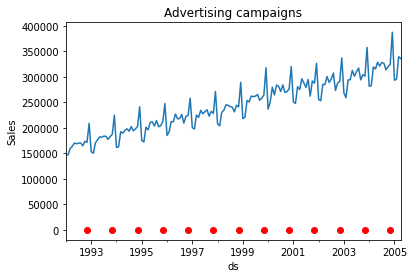

In [4]:
df['y'].plot()
df['campaign'].plot(marker='o', color='red')

plt.title('Advertising campaigns')
plt.ylabel('Sales')

In red, we see the time points at which we launched an advertisement campaign.

## Time since last campaign

In [5]:
# Add date columns.

df['date'] = df.index

In [6]:
# Calculate time since last advertising campaign.

df["time_since"] = df["date"] - df["date"].where(df["campaign"] == 1).ffill()

df.head()

,y,campaign,date,time_since
ds,,,,
1992-01-01,146376,NaN,1992-01-01,NaT
1992-02-01,147079,NaN,1992-02-01,NaT
1992-03-01,159336,NaN,1992-03-01,NaT
1992-04-01,163669,NaN,1992-04-01,NaT
1992-05-01,170068,NaN,1992-05-01,NaT


In [7]:
df['time_since'].value_counts()

0 days      13
61 days     13
92 days     13
30 days     13
120 days    10
151 days    10
273 days     9
334 days     9
304 days     9
242 days     9
212 days     9
181 days     9
121 days     3
152 days     3
182 days     3
213 days     3
243 days     3
274 days     3
305 days     3
335 days     3
Name: time_since, dtype: int64

In [8]:
df["time_since"] = (
    df["date"] - df["date"].where(df["campaign"] == 1).ffill()).dt.days

Text(0, 0.5, 'Sales')

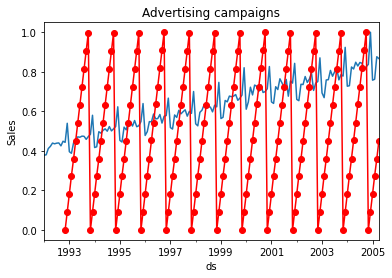

In [9]:
(df['y'] / df['y'].max()).plot()
(df['time_since'] / df['time_since'].max()).plot(marker='o', color='red')

plt.title('Advertising campaigns')
plt.ylabel('Sales')

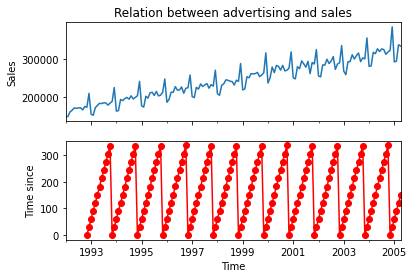

In [10]:
ax1 = plt.subplot(211)
df['y'].plot()
plt.ylabel('Sales')
plt.title('Relation between advertising and sales')

ax2 = plt.subplot(212, sharex=ax1)
df['time_since'].plot(marker='o', color='red')
plt.ylabel('Time since')
plt.xlabel('Time')

plt.show()

### Dissect the procedure

Now, let's cut down the procedure into pieces to understand what is going on.

In [11]:
# First, we select the start times. That is the 
# time of the advertisement campaign.

# I only show some values for better visualization

df["date"].where(df["campaign"]==1)[100:110]

ds
2000-05-01          NaT
2000-06-01          NaT
2000-07-01          NaT
2000-08-01          NaT
2000-09-01          NaT
2000-10-01          NaT
2000-11-01   2000-11-01
2000-12-01          NaT
2001-01-01          NaT
2001-02-01          NaT
Name: date, dtype: datetime64[ns]

In [12]:
# Now we carry the date of the campaign forward
# till the next available campaign date.

df["date"].where(df["campaign"]==1).ffill()[100:110]

ds
2000-05-01   1999-11-01
2000-06-01   1999-11-01
2000-07-01   1999-11-01
2000-08-01   1999-11-01
2000-09-01   1999-11-01
2000-10-01   1999-11-01
2000-11-01   2000-11-01
2000-12-01   2000-11-01
2001-01-01   2000-11-01
2001-02-01   2000-11-01
Name: date, dtype: datetime64[ns]

In [13]:
# And now we just substract the real date from the
# campaign date

(df["date"] - df["date"].where(df["campaign"] == 1).ffill())[100:110]

ds
2000-05-01   182 days
2000-06-01   213 days
2000-07-01   243 days
2000-08-01   274 days
2000-09-01   305 days
2000-10-01   335 days
2000-11-01     0 days
2000-12-01    30 days
2001-01-01    61 days
2001-02-01    92 days
Name: date, dtype: timedelta64[ns]

In [14]:
# Finally, we extract the days as integers

(df["date"] - df["date"].where(df["campaign"] == 1).ffill()).dt.days[100:110]

ds
2000-05-01    182.0
2000-06-01    213.0
2000-07-01    243.0
2000-08-01    274.0
2000-09-01    305.0
2000-10-01    335.0
2000-11-01      0.0
2000-12-01     30.0
2001-01-01     61.0
2001-02-01     92.0
Name: date, dtype: float64

## Time interval

Something that may be useful when our timestamps are not equidistant is determining the time between observations in our time series.

We do this very easily with pandas diff()

In [15]:
tmp = pd.Series(df.index).diff()

tmp

0         NaT
1     31 days
2     29 days
3     31 days
4     30 days
        ...  
155   30 days
156   31 days
157   31 days
158   28 days
159   31 days
Name: ds, Length: 160, dtype: timedelta64[ns]

Our index corresponds to monthly sales, so we can use these values to normalize the sales volume per number of days in the month. In longer months, we will probably sell more, just because we have a few more days to sell.

In the previous cell, we capture the time difference in days, which is probably useful for our data. But we can change the timedelta units if we want to, as follows:

In [16]:
tmp = tmp / np.timedelta64(1,'h')

tmp

0        NaN
1      744.0
2      696.0
3      744.0
4      720.0
       ...  
155    720.0
156    744.0
157    744.0
158    672.0
159    744.0
Name: ds, Length: 160, dtype: float64

That will be all for this notebook!